<a href="https://colab.research.google.com/github/TBLinhDan/Project_Image_Retrieval/blob/feature%2Fmodule2-Project_Image_Retrieval/ProjectM2_Images_Retrieval_Optimize_with_VectorDatabase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**III. Optimize image query process  with Vector Database**  
##**1. Download image dataset and unzip**

In [1]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=42bf3774-279c-451f-99e5-f16f60c43779
To: /content/data.zip
100% 76.1M/76.1M [00:00<00:00, 93.4MB/s]


In [2]:
!unzip data

Archive:  data.zip
   creating: data/
   creating: data/.ipynb_checkpoints/
   creating: data/test/
   creating: data/test/American_egret/
  inflating: data/test/American_egret/n02009912_2473.JPEG  
   creating: data/test/Doberman/
  inflating: data/test/Doberman/n02107142_52285.JPEG  
   creating: data/test/Rhodesian_ridgeback/
  inflating: data/test/Rhodesian_ridgeback/n02087394_18723.JPEG  
   creating: data/test/African_crocodile/
  inflating: data/test/African_crocodile/n01697457_18534.JPEG  
   creating: data/test/Lakeland_terrier/
  inflating: data/test/Lakeland_terrier/n02095570_4644.JPEG  
   creating: data/test/ambulance/
  inflating: data/test/ambulance/n02701002_2311.JPEG  
   creating: data/test/apiary/
  inflating: data/test/apiary/n02727426_4398.JPEG  
   creating: data/test/bannister/
  inflating: data/test/bannister/n02788148_47071.JPEG  
   creating: data/test/basketball/
  inflating: data/test/basketball/n02802426_12693.JPEG  
   creating: data/test/barn_spider/
  in

##**2. Import some necessary libraries:**


In [3]:
%pip install chromadb
%pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 112.1 MB/s eta 0:00:00

In [7]:
import os
import chromadb
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

##**3. Process Data**

Tạo list các đường dẫn cho ảnh lấy embedding và được đưa vào database

dic_categories change to class_name

In [8]:
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
HNSW_SPACE = "hnsw:space"


In [9]:
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

In [10]:
data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)
files_path

['data/train/African_crocodile/n01697457_1331.JPEG',
 'data/train/African_crocodile/n01697457_260.JPEG',
 'data/train/African_crocodile/n01697457_14906.JPEG',
 'data/train/African_crocodile/n01697457_8331.JPEG',
 'data/train/African_crocodile/n01697457_8136.JPEG',
 'data/train/African_crocodile/n01697457_5586.JPEG',
 'data/train/African_crocodile/n01697457_85.JPEG',
 'data/train/African_crocodile/n01697457_18587.JPEG',
 'data/train/African_crocodile/n01697457_10393.JPEG',
 'data/train/African_crocodile/n01697457_104.JPEG',
 'data/train/American_egret/n02009912_36395.JPEG',
 'data/train/American_egret/n02009912_8563.JPEG',
 'data/train/American_egret/n02009912_1358.JPEG',
 'data/train/American_egret/n02009912_5700.JPEG',
 'data/train/American_egret/n02009912_13895.JPEG',
 'data/train/American_egret/n02009912_16896.JPEG',
 'data/train/American_egret/n02009912_15872.JPEG',
 'data/train/American_egret/n02009912_7609.JPEG',
 'data/train/American_egret/n02009912_26245.JPEG',
 'data/train/Ame

In [11]:
def plot_results(image_path, files_path, results):
    query_image = Image.open(image_path).resize((448,448))
    images = [query_image]
    class_name = []
    for id_img in results['ids'][0]:
        id_img = int(id_img.split('_')[-1])
        img_path = files_path[id_img]
        img = Image.open(img_path).resize((448,448))
        images.append(img)
        class_name.append(img_path.split('/')[2])

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    # Iterate through images and plot them
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        if i == 0:
            ax.set_title(f"Query Image: {image_path.split('/')[2]}")
        else:
            ax.set_title(f"Top {i+1}: {class_name[i-1]}")
        ax.axis('off')  # Hide axes
    # Display the plot
    plt.show()

## Image Embedding

In [12]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=np.array(image))
    return embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
img = Image.open('data/train/African_crocodile/n01697457_260.JPEG')
get_single_image_embedding(image=img)

[0.020757177844643593,
 0.017005091533064842,
 -0.05467665195465088,
 0.01930321380496025,
 0.00038289008080028,
 0.012467814609408379,
 -0.016283445060253143,
 -0.0021528410725295544,
 0.050817880779504776,
 0.013185838237404823,
 -0.01208943035453558,
 0.007774867117404938,
 0.01889331266283989,
 -0.03941911831498146,
 0.011427964083850384,
 0.022981468588113785,
 -0.06463996320962906,
 0.026438042521476746,
 0.014886362478137016,
 0.002710734261199832,
 -0.044038254767656326,
 -0.006419013720005751,
 0.005665387958288193,
 -0.030828330665826797,
 -0.01642996072769165,
 -0.0003536638687364757,
 0.005325682926923037,
 -0.01526609342545271,
 -0.007757566403597593,
 -0.025533441454172134,
 -0.012705388478934765,
 0.019180215895175934,
 0.0023711705580353737,
 0.014735797420144081,
 -0.026996051892638206,
 -0.039406631141901016,
 0.015418069437146187,
 -0.014308145269751549,
 -0.032431311905384064,
 0.01032754871994257,
 -0.016555195674300194,
 0.04119733348488808,
 -0.03550386801362038,

## Chromadb L2 Embedding Collection

Tạo embedding collection từ các đường dẫn file ảnh data ở bước trên

In [13]:
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image = Image.open(filepath)
        embedding = get_single_image_embedding(image=image)
        embeddings.append(embedding)
    collection.add(
        embeddings=embeddings,
        ids=ids
    )

In [14]:
# Create a Chroma Client
chroma_client = chromadb.Client()
# Create a collection
l2_collection = chroma_client.get_or_create_collection(name="l2_collection",
                                                           metadata={HNSW_SPACE: "l2"})
add_embedding(collection=l2_collection, files_path=files_path)

595it [01:57,  5.06it/s]


## Search Image With L2 Collection

In [15]:
def search(image_path, collection, n_results):
    query_image = Image.open(image_path)
    query_embedding = get_single_image_embedding(query_image)
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results # how many results to return
    )
    return results

In [16]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
l2_results = search(image_path=test_path, collection=l2_collection, n_results=5)

In [17]:
l2_results

{'ids': [['id_18', 'id_11', 'id_17', 'id_14', 'id_19']],
 'distances': [[0.40494874119758606,
   0.4122699201107025,
   0.5080230832099915,
   0.5198448896408081,
   0.5294203758239746]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

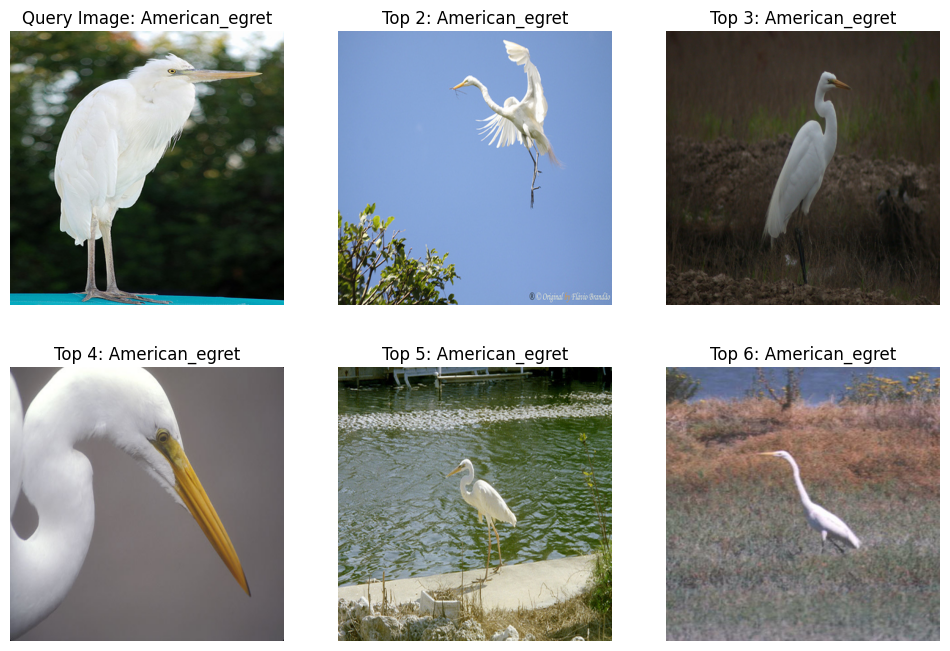

In [18]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

## Search Image With Cosine similarity Collection

---



In [19]:
# Create a collection
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection",
                                                           metadata={HNSW_SPACE: "cosine"})
add_embedding(collection=cosine_collection, files_path=files_path)

595it [02:00,  4.93it/s]


In [23]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[10]
cosine_results = search(image_path=test_path, collection=cosine_collection, n_results=5)

In [24]:
cosine_results

{'ids': [['id_101', 'id_96', 'id_97', 'id_99', 'id_100']],
 'distances': [[0.46826571226119995,
   0.4946631193161011,
   0.5340281128883362,
   0.5433312654495239,
   0.5522228479385376]],
 'metadatas': [[None, None, None, None, None]],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

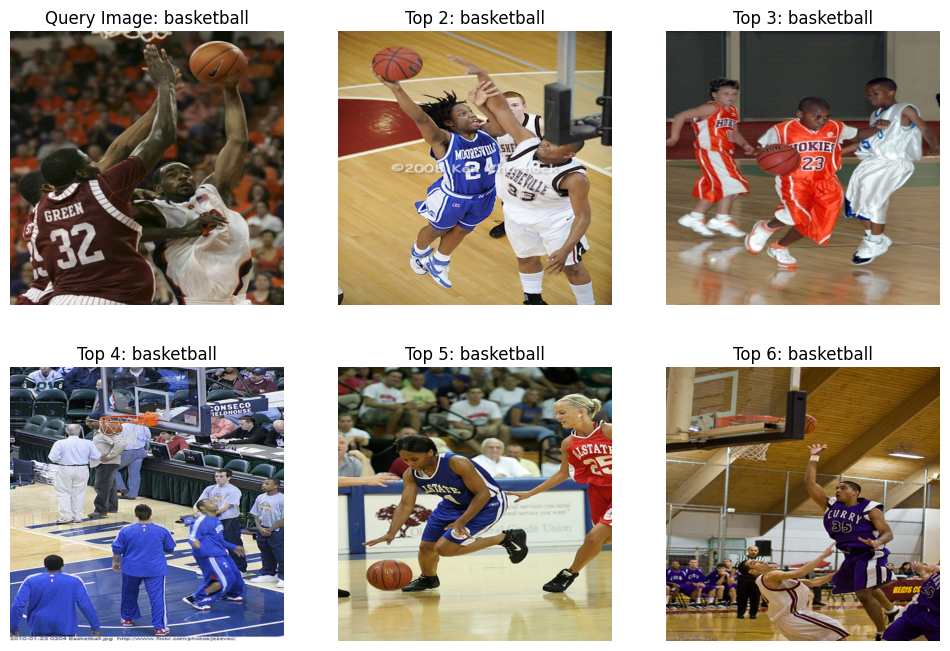

In [25]:
plot_results(image_path=test_path, files_path=files_path, results=cosine_results)